In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as stats
from scipy.stats import linregress
import json
from pprint import pprint

#BITCOIN API: url setup
url = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
default = 'start=2020-01-01&end=2020-12-31'

# set start and end date variables
# NOTE: must stay within 2020 range, csv files (dow & gold) are limited to this range
start_date = '2020-01-01'
end_date = '2020-12-31'

# DOW: file to Load, read csv, dataframe
file_to_load = "data/dow.csv"
dow_data = pd.read_csv(file_to_load)
dow_data_df = pd.DataFrame(dow_data)

# GOLD: file to load, read csv, dataframe
file_to_load = "data/gold.csv"
gold_data = pd.read_csv(file_to_load)
gold_data_df = pd.DataFrame(gold_data)
gold_data_df.columns = gold_data_df.columns.tolist()[:1] + ['Close'] + gold_data_df.columns.tolist()[2:]

In [88]:
# BITCOIN: create query url for start and end date, request json
query_url = f'{url}start={start_date}&end={end_date}'
pprint(requests.get(query_url).json())

{'bpi': {'2020-01-01': 7188.4633,
         '2020-01-02': 6961.5683,
         '2020-01-03': 7346.58,
         '2020-01-04': 7355.855,
         '2020-01-05': 7356.3117,
         '2020-01-06': 7761.825,
         '2020-01-07': 8157.7617,
         '2020-01-08': 8042.8733,
         '2020-01-09': 7816.9233,
         '2020-01-10': 8189.265,
         '2020-01-11': 8016.4267,
         '2020-01-12': 8178.8833,
         '2020-01-13': 8105.4783,
         '2020-01-14': 8807.4267,
         '2020-01-15': 8808.4867,
         '2020-01-16': 8716.9133,
         '2020-01-17': 8890.25,
         '2020-01-18': 8901.17,
         '2020-01-19': 8698.5717,
         '2020-01-20': 8631.2883,
         '2020-01-21': 8727.6033,
         '2020-01-22': 8661.01,
         '2020-01-23': 8392.145,
         '2020-01-24': 8436.49,
         '2020-01-25': 8337.1017,
         '2020-01-26': 8602.7417,
         '2020-01-27': 8901.5067,
         '2020-01-28': 9393.2733,
         '2020-01-29': 9290.46,
         '2020-01-30': 9508.72

In [89]:
# BITCOIN: create response, create dataframe of date range results from API
response = requests.get(query_url).json()
my_dict = response['bpi']
test_df = pd.DataFrame(list(my_dict.items()),columns = ['close date','close price']) 

# test_df

In [90]:
# DOW: clean data (take out out-of-range data based on start_/end_date variables above)
# return only date and close price columns
dow_cleaned = dow_data_df.loc[(dow_data_df['Date'] >= start_date) & (dow_data_df['Date'] <= end_date)]
dow_cleaned = dow_cleaned[['Date','Close']]

# rename date column to prep for merge
dow_df = dow_cleaned.rename(columns={'Date':'close date'})

# dow_cleaned

In [91]:
# GOLD: clean data - convert to_datetime
gold_data_df['Date'] = pd.to_datetime(gold_data_df['Date'])

# clean data - take out out-of-range data based on start_/end_date variables above
# return only date and close price columns
gold_cleaned = gold_data_df.loc[(gold_data_df['Date'] >= start_date) & (gold_data_df['Date'] <= end_date)]
gold_cleaned = gold_cleaned.sort_values(by=['Date']).reset_index(drop=True)
gold_cleaned = gold_cleaned.iloc[:,0:2]

# rename date column to prep for merge
gold_df = gold_cleaned.rename(columns={'Date':'close date'})

# gold_df

In [92]:
# BITCOIN & 
merged = pd.merge(test_df, dow_df, on='close date', how='left')
merged['close date'] = pd.to_datetime(merged['close date'])

merged = pd.merge(merged, gold_df, on='close date', how='left', suffixes=('_dow','_gold'))
merged = merged.rename(columns={'close date':'Date','close price':'Bitcoin', 'Close_dow':'Dow', 'Close_gold':'Gold'})

# merged

In [93]:
#drop NaN values (aka weekends & holidays)
merged = merged.dropna()
merged


,Date,Bitcoin,Dow,Gold
1,2020-01-02,6961.5683,28868.800781,1528.1
2,2020-01-03,7346.5800,28634.880859,1549.2
5,2020-01-06,7761.8250,28703.380859,1568.8
6,2020-01-07,8157.7617,28583.679688,1574.3
7,2020-01-08,8042.8733,28745.089844,1560.2
...,...,...,...,...
358,2020-12-24,23729.6483,30199.869141,1883.2
362,2020-12-28,27041.8667,30403.970703,1880.4
363,2020-12-29,27353.9783,30335.669922,1882.9
364,2020-12-30,28886.0400,30409.560547,1893.4


In [94]:
# setting axes to variables
bitcoin_x = merged['Bitcoin']
dow_x = merged['Dow']
gold_x = merged['Gold']
all_y = merged['Date']

In [95]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

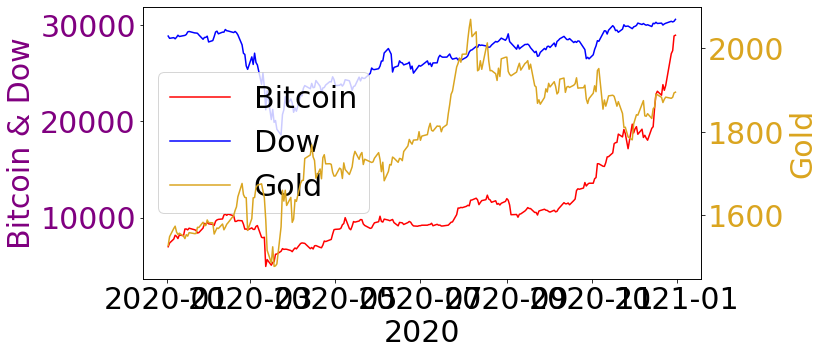

In [96]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()

# here's the link to the info on overlaying two axes: 
# https://matplotlib.org/gallery/api/two_scales.html

# link to combining all plots into one legend:
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend

# link to changing fig size
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

In [97]:
merged.describe()

,Bitcoin,Dow,Gold
count,253.000000,253.000000,253.000000
mean,11143.665731,26890.673612,1779.100791
std,4298.440906,2521.704585,142.015038
min,4914.085000,18591.929688,1477.900000
25%,8890.250000,25595.800781,1675.700000
50%,9730.365000,27480.029297,1788.100000
75%,11744.012700,28823.769531,1895.500000
max,28956.265000,30606.480469,2069.400000


In [98]:
#ANOVA ALL
bit_group = merged_wpct['% Chg Bitcoin'].dropna()
dow_group = merged_wpct['% Chg Dow'].dropna()
gold_group = merged_wpct['% Chg Gold'].dropna()

stats.f_oneway(bit_group, dow_group, gold_group)
# group1

F_onewayResult(statistic=2.9860085328612738, pvalue=0.05109157353191418)

In [99]:
#ANOVA BITCOIN V DOW
stats.f_oneway(bit_group, dow_group)

F_onewayResult(statistic=3.3871585817347682, pvalue=0.06630089219158232)

In [100]:
#ANOVA BITCOIN V GOLD
stats.f_oneway(bit_group, gold_group)

F_onewayResult(statistic=3.5209145827217982, pvalue=0.061183567321414646)

In [101]:
#ANOVA DOW V GOLD
stats.f_oneway(dow_group, gold_group)

F_onewayResult(statistic=0.035246301301690666, pvalue=0.8511569544557342)

In [102]:
#Settting variables for % change
pct_dow = merged['Dow'].pct_change()
pct_bitcoin = merged['Bitcoin'].pct_change()
pct_gold = merged['Gold'].pct_change()

#adding to DF
merged_wpct = merged
merged_wpct['% Chg Bitcoin'] = pct_bitcoin
merged_wpct['% Chg Dow'] = pct_dow
merged_wpct['% Chg Gold'] = pct_gold 
merged_wpct.dropna(how='any', inplace=True)


In [103]:
curr_list = ['Bitcoin', 'Dow', 'Gold', '% Chg Bitcoin', '% Chg Dow', '% Chg Gold']
all_list = [] 

for currency in curr_list:
    item = merged_wpct[currency].tolist()
    # add subset  
    all_list.append(item)

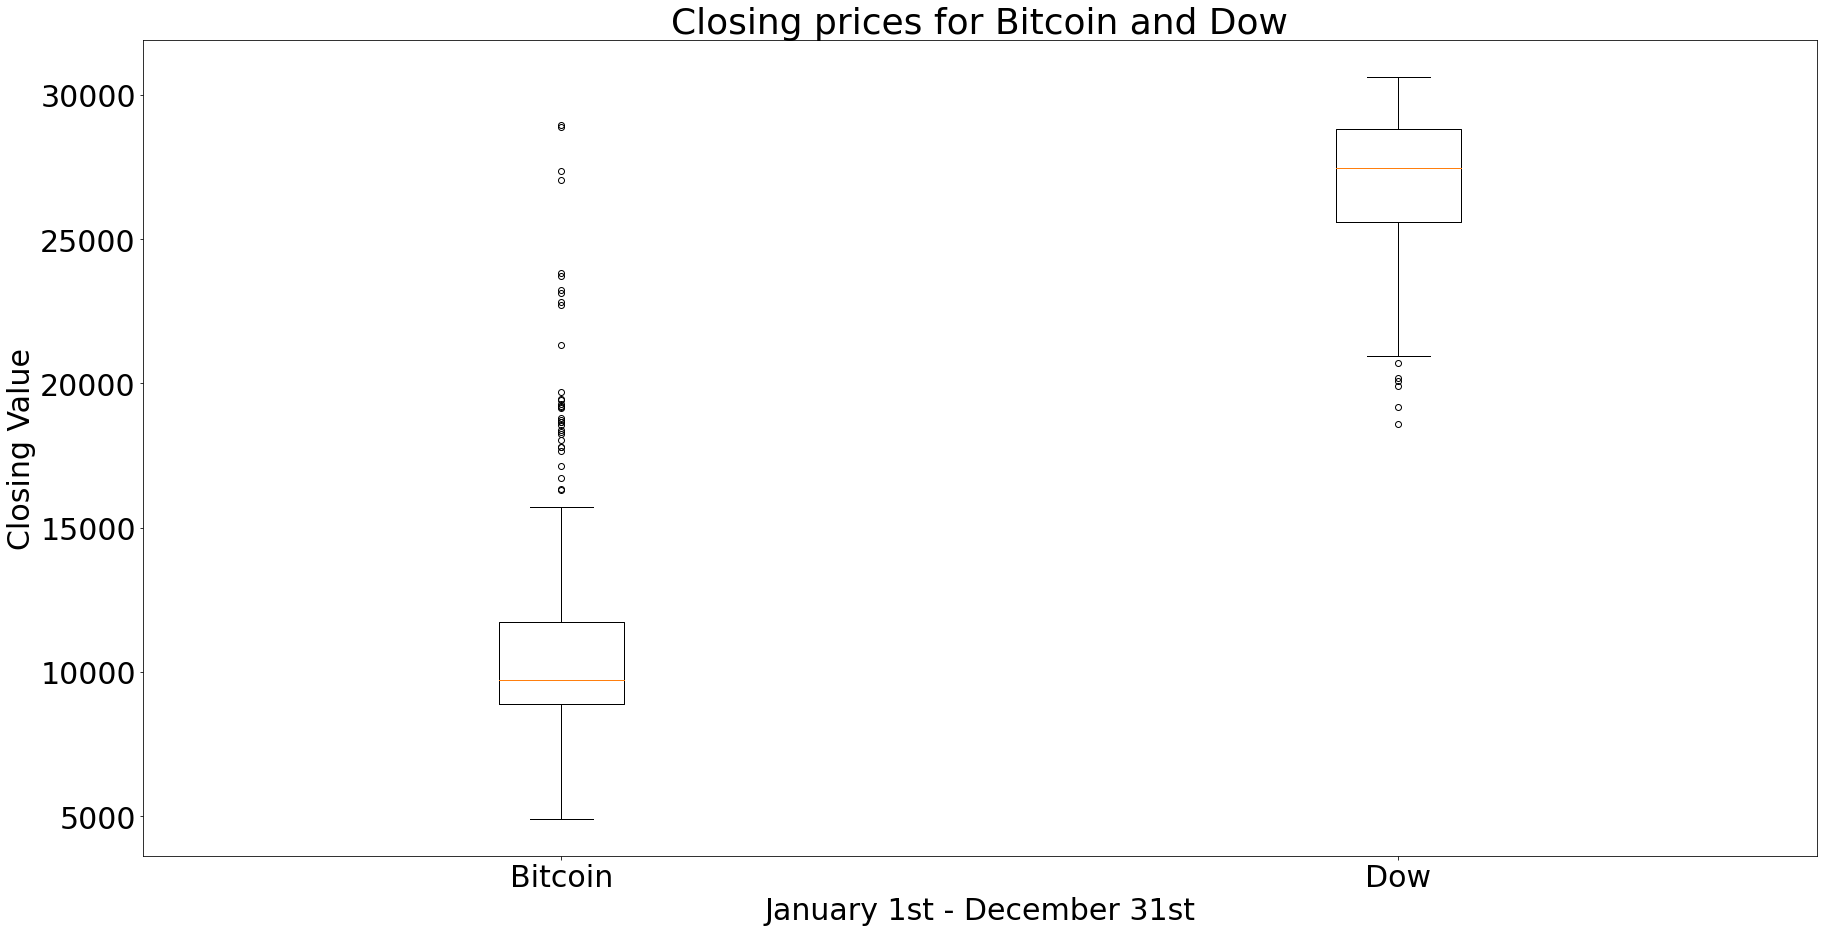

In [104]:
# BITCOIN & DOW boxplots
fig1, ax1 = plt.subplots()

ax1.set_title('Closing prices for Bitcoin and Dow')
ax1.set_ylabel('Closing Value')
ax1.boxplot(all_list[:2])
plt.xlabel('January 1st - December 31st')
plt.xticks([1,2], curr_list[:2])
plt.show()

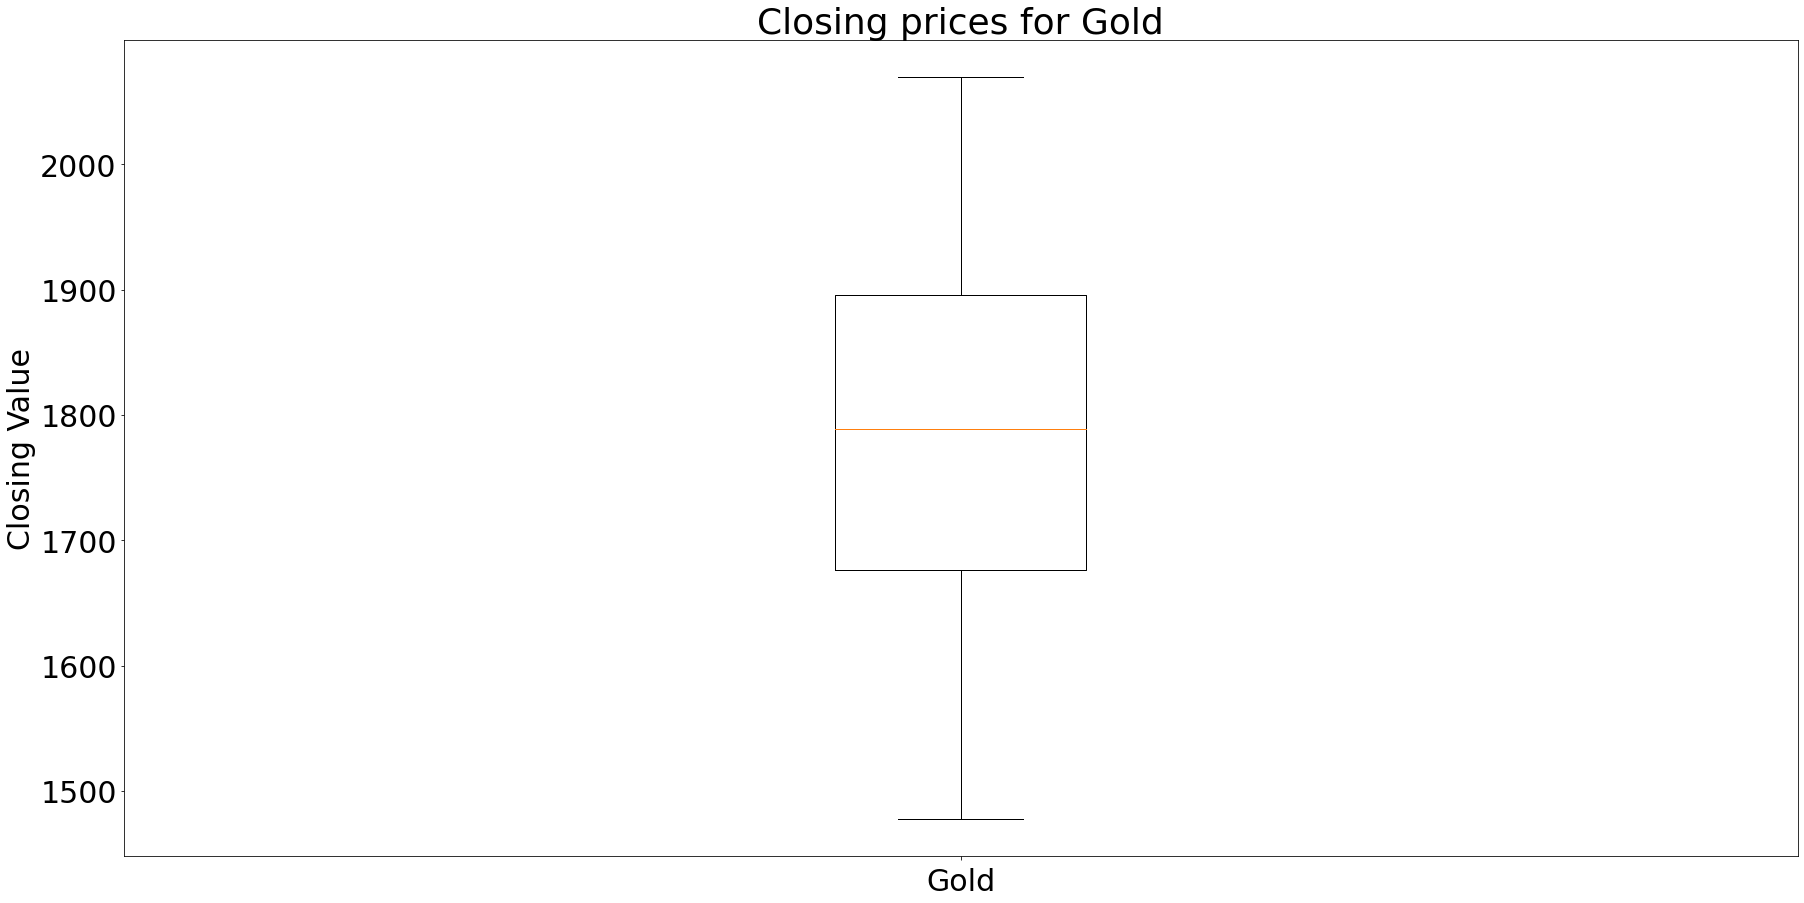

In [105]:
#GOLD Boxplot
fig1, ax1 = plt.subplots()

ax1.set_title('Closing prices for Gold')
ax1.set_ylabel('Closing Value')
ax1.boxplot(all_list[2])
plt.xlabel('Gold')
plt.xticks([1],'')
plt.show()

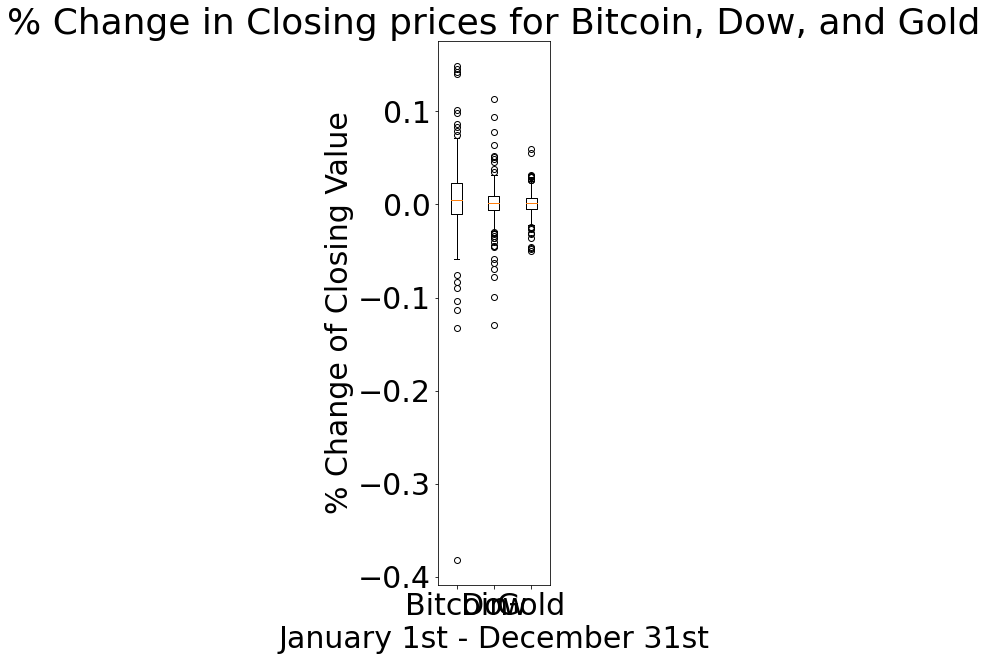

In [125]:
# # BITCOIN & DOW boxplots
fig1, ax1 = plt.subplots()

ax1.set_title('% Change in Closing prices for Bitcoin, Dow, and Gold')
ax1.set_ylabel('% Change of Closing Value')
ax1.boxplot(all_list[3:6])
plt.xlabel('January 1st - December 31st')
plt.xticks([1,2,3], ['Bitcoin', 'Dow', 'Gold'])
fig1.set_size_inches(2, 10, forward=True)
plt.show()

#OUTLIER: Bitcoin had an outlier around -0.38% change, resulting in a skewed boxplot chart

### COVID lockdown of borders: 02/28/2020-03/26/2020

In [107]:
#COVID SECTION: Look between dates 2020-02-28 through 2020-03-26 (Meredith)
start_date = '2020-02-28'
end_date = '2020-03-26'

covid_df = merged.loc[(merged['Date'] >= start_date) & (merged['Date'] <= end_date)]

covid_df

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
58,2020-02-28,8715.6617,25409.359375,1564.1,-0.011447,-0.013866,-0.047732
61,2020-03-02,8926.2517,26703.320313,1592.3,0.024162,0.050925,0.018030
62,2020-03-03,8768.1800,25917.410156,1642.1,-0.017709,-0.029431,0.031276
63,2020-03-04,8767.8867,27090.859375,1643.0,-0.000033,0.045276,0.000548
64,2020-03-05,9073.2750,26121.279297,1666.4,0.034830,-0.035790,0.014242
65,2020-03-06,9165.1517,25864.779297,1672.4,0.010126,-0.009820,0.003601
68,2020-03-09,7944.4500,23851.019531,1675.7,-0.133189,-0.077857,0.001973
69,2020-03-10,7899.2267,25018.160156,1659.1,-0.005692,0.048935,-0.009906
70,2020-03-11,7951.1700,23553.220703,1642.3,0.006576,-0.058555,-0.010126
71,2020-03-12,4914.0850,21200.619141,1590.3,-0.381967,-0.099884,-0.031663


In [108]:
# setting axes to variables
bitcoin_x = covid_df['Bitcoin']
dow_x = covid_df['Dow']
gold_x = covid_df['Gold']
all_y = covid_df['Date']

In [109]:
# set up colors
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

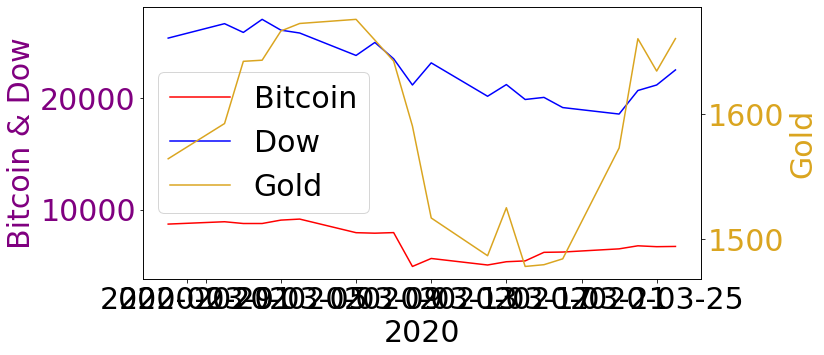

In [110]:
# plot bitcoin and dow on left y-axis
fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()


In [111]:
covid_df.describe()
# for Covid dates

,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,7129.578345,22877.559863,1592.225000,-0.006722,-0.004589,0.000945
std,1474.355594,2740.331625,73.303212,0.108824,0.065413,0.029306
min,4914.085000,18591.929688,1477.900000,-0.381967,-0.129265,-0.047732
25%,6042.596675,20575.812500,1522.850000,-0.011507,-0.048735,-0.016678
50%,6738.365850,22868.894532,1613.300000,0.005419,-0.011843,0.001460
75%,8728.717950,25523.214356,1659.375000,0.036667,0.049432,0.016439
max,9165.151700,27090.859375,1675.700000,0.145600,0.113650,0.059771


### Social Unrest (George Floyd) Data '05-26-2020' - '06-25-2020'

In [112]:
start_date = '2020-05-25'
end_date = '2020-06-05'
gf_df = merged.loc[(merged['Date'] >= start_date) & (merged['Date'] <= end_date)]

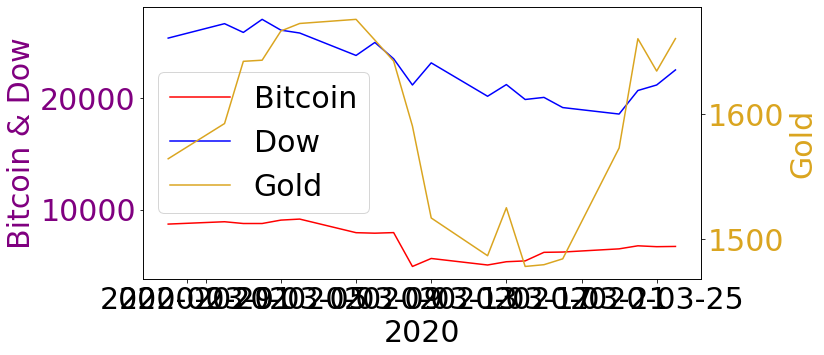

In [113]:
color_bit = 'red'
color_dow = 'blue'
color_gold = 'goldenrod'
color_label = 'purple'

fig, ax1 = plt.subplots()
plot1 = ax1.plot(all_y, bitcoin_x, color=color_bit, label='Bitcoin')
plot2 = ax1.plot(all_y, dow_x, color=color_dow, label='Dow')
ax1.tick_params(axis='y', labelcolor=color_label)
ax1.set_xlabel('2020')
ax1.set_ylabel('Bitcoin & Dow', color=color_label)
ax1.plot()

# set up second y-axis *see link*
ax2 = ax1.twinx()

# plot second y-axis
ax2.set_ylabel('Gold', color=color_gold)
plot3 = ax2.plot(all_y, gold_x, color=color_gold, label= 'Gold')
ax2.tick_params(axis='y', labelcolor=color_gold)

## combining all plots into one legen *see link*
plots = plot1+plot2+plot3
labels = [p.get_label() for p in plots]
ax1.legend(plots, labels, loc=0)

# set fig size for readability *see link*
fig.set_size_inches(10, 5, forward=True)

plt.show()

In [114]:
bitcoin_x = gf_df['Bitcoin']
dow_x = gf_df['Dow']
gold_x = gf_df['Gold']
all_y = gf_df['Date']
percent_dow = dow_x.pct_change()
percent_dow
percent_bitcoin = bitcoin_x.pct_change()
percent_bitcoin
percent_gold = gold_x.pct_change()
percent_gold

#adding to DF
gf_df['% Chg Dow'] = percent_dow
gf_df.head()

gf_df['% Chg Bitcoin'] = percent_bitcoin
gf_df.head()

gf_df['% Chg Gold'] = percent_gold 
gf_df.head(10)
gf_df.fillna(0)


C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
146,2020-05-26,8871.050,24995.109375,1728.2,0.000000,0.000000,0.000000
147,2020-05-27,8923.050,25548.269531,1726.8,0.005862,0.022131,-0.000810
148,2020-05-28,9207.950,25400.640625,1728.3,0.031929,-0.005778,0.000869
149,2020-05-29,9448.365,25383.109375,1736.9,0.026110,-0.000690,0.004976
152,2020-06-01,9564.950,25475.019531,1750.3,0.012339,0.003621,0.007715
153,2020-06-02,10136.500,25742.650391,1734.0,0.059755,0.010506,-0.009313
154,2020-06-03,9594.450,26269.890625,1704.8,-0.053475,0.020481,-0.016840
155,2020-06-04,9529.550,26281.820313,1727.4,-0.006764,0.000454,0.013257
156,2020-06-05,9836.805,27110.980469,1683.0,0.032242,0.031549,-0.025703


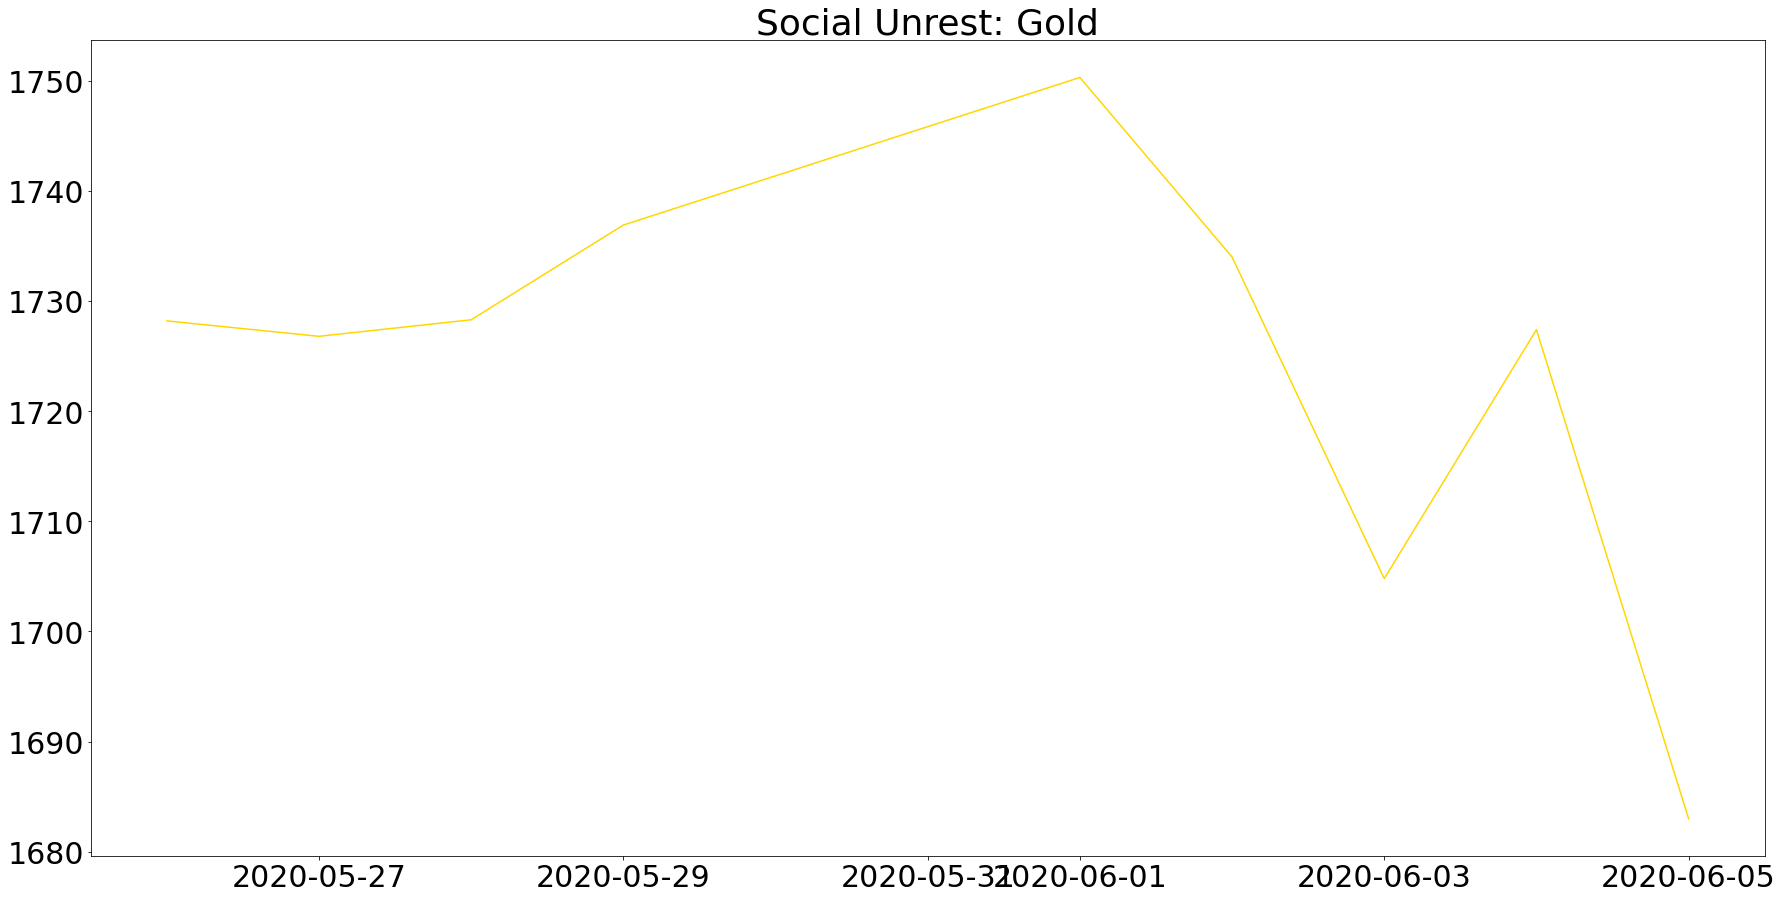

In [115]:
Gold = plt.plot(all_y, gold_x, color="gold", label="Gold")
fig.set_size_inches(10, 5, forward=True)
plt.title("Social Unrest: Gold")
plt.rcParams["figure.figsize"] = (60,15)
plt.rcParams.update({'font.size': 5})

## Election Data '11-01-2020' - '11-14-2020'

In [116]:
##Set dates for election.  Used 2 weeks due to delayed election results
start_date = '11-01-2020'
end_date = '11-14-2020'

election_df = merged.loc[(merged['Date'] >= start_date) & (merged['Date'] <= end_date)]
election_df

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
306,2020-11-02,13567.2233,26925.050781,1892.5,0.000022,0.015978,0.006702
307,2020-11-03,14030.7900,27480.029297,1910.4,0.034168,0.020612,0.009458
308,2020-11-04,14158.8100,27847.660156,1896.2,0.009124,0.013378,-0.007433
309,2020-11-05,15593.5550,28390.179688,1946.8,0.101332,0.019482,0.026685
310,2020-11-06,15589.0033,28323.400391,1951.7,-0.000292,-0.002352,0.002517
313,2020-11-09,15334.8700,29157.970703,1854.4,-0.016302,0.029466,-0.049854
314,2020-11-10,15313.4433,29420.919922,1876.4,-0.001397,0.009018,0.011864
315,2020-11-11,15706.5400,29397.630859,1861.6,0.025670,-0.000792,-0.007887
316,2020-11-12,16301.0267,29080.169922,1873.3,0.037850,-0.010799,0.006285
317,2020-11-13,16330.3433,29479.810547,1886.2,0.001798,0.013743,0.006886


In [117]:
# setting axes to variables for 
bitcoin_x = election_df['Bitcoin']
dow_x = election_df['Dow']
gold_x = election_df['Gold']
all_y = election_df['Date']

The hypothesis is that bitcoin would behave like a hedge asset such as gold during economic uncertainty.  One would interpret that Gold/Bitcoin prices would increase during uncertainty leading up to the election and level off as confidence was restored in the market once a president was elected. 

In [118]:
#Settting variables for % change
percent_dow = dow_x.pct_change()
percent_dow
percent_bitcoin = bitcoin_x.pct_change()
percent_bitcoin
percent_gold = gold_x.pct_change()
percent_gold

#adding to DF
election_df['% Chg Dow'] = percent_dow
election_df.head()

election_df['% Chg Bitcoin'] = percent_bitcoin
election_df.head()

election_df['% Chg Gold'] = percent_gold 
election_df.head(10)

election_df.fillna(0)

C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\chels\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Date,Bitcoin,Dow,Gold,% Chg Bitcoin,% Chg Dow,% Chg Gold
306,2020-11-02,13567.2233,26925.050781,1892.5,0.000000,0.000000,0.000000
307,2020-11-03,14030.7900,27480.029297,1910.4,0.034168,0.020612,0.009458
308,2020-11-04,14158.8100,27847.660156,1896.2,0.009124,0.013378,-0.007433
309,2020-11-05,15593.5550,28390.179688,1946.8,0.101332,0.019482,0.026685
310,2020-11-06,15589.0033,28323.400391,1951.7,-0.000292,-0.002352,0.002517
313,2020-11-09,15334.8700,29157.970703,1854.4,-0.016302,0.029466,-0.049854
314,2020-11-10,15313.4433,29420.919922,1876.4,-0.001397,0.009018,0.011864
315,2020-11-11,15706.5400,29397.630859,1861.6,0.025670,-0.000792,-0.007887
316,2020-11-12,16301.0267,29080.169922,1873.3,0.037850,-0.010799,0.006285
317,2020-11-13,16330.3433,29479.810547,1886.2,0.001798,0.013743,0.006886


To normalize the Data to test against P-values, we calculated the % change among Bitcoin/Dow/Gold

F_onewayResult(statistic=2.477190473682874, pvalue=0.13507226312302117)
^Bitcoin against Gold
F_onewayResult(statistic=0.80418009501826, pvalue=0.3831413643210435)
^Bitcoin against Dow


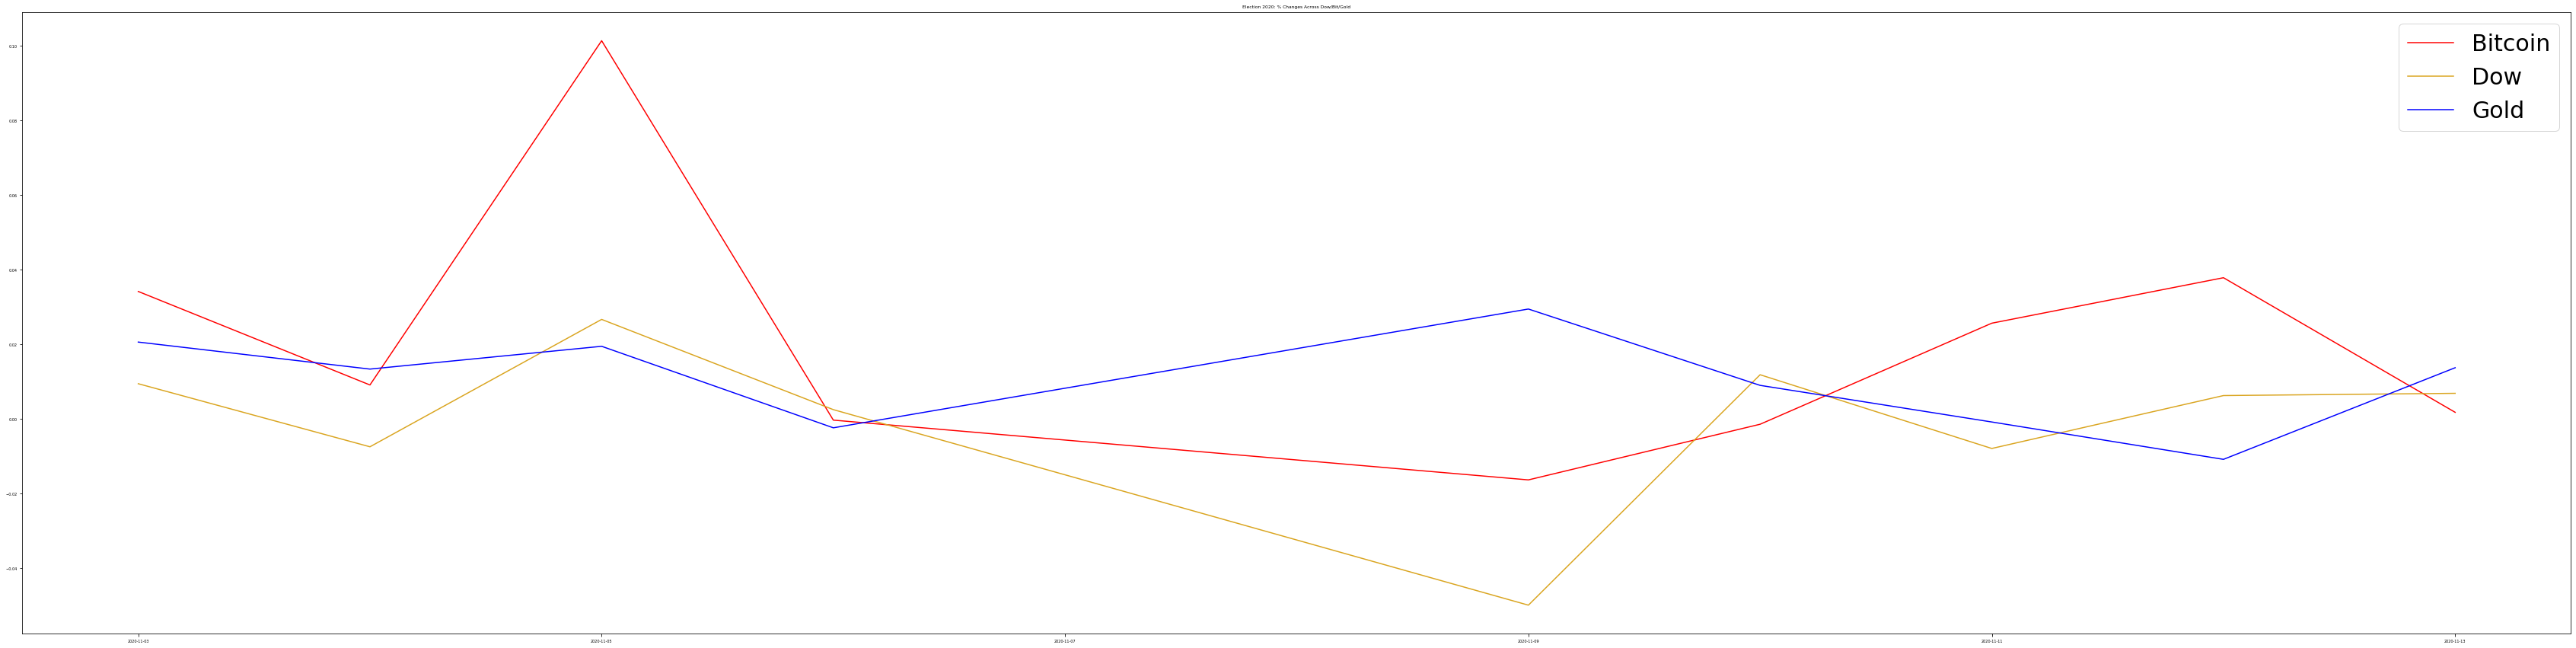

In [119]:
#Anova Test 
group_dow = election_df['% Chg Dow'].dropna()
group_gold = election_df['% Chg Gold'].dropna()
group_bitcoin = election_df['% Chg Bitcoin'].dropna()
print(stats.f_oneway(group_bitcoin, group_gold))
print('^Bitcoin against Gold')
print(stats.f_oneway(group_bitcoin, group_dow))
print('^Bitcoin against Dow')

#Plotting % chg
Bitcoin = plt.plot(all_y, election_df['% Chg Bitcoin'], color="red", label="Bitcoin")
Gold = plt.plot(all_y, election_df['% Chg Gold'], color = "goldenrod", label = "Gold")
Dow = plt.plot(all_y,  election_df['% Chg Dow'], color = "blue", label = "Dow")
plt.title("Election 2020: % Changes Across Dow/Bit/Gold")
plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams.update({'font.size': 30})
plt.legend(labels)

Comparing the sample election data sets for each variable failed the hypothesis for all p-values..  The lower p-value was associated with Bitcoin and Gold. This was likely due to a small sampling of dates. However, the % change behavior shows that Bitcoin and Gold rose drastically during the timeframe where a President had not been called (11/4 - 11/5).  There was a marked decrease in Bitcoin and Gold prices once the President was called over the weekend (Major News outlet called Biden's presidency on 11/7) while the Dow rose, this behavior would be in line that Bitcoin was reacting as a type of hedge asset. 

In [120]:
# set up colors
color_bit = 'red'
color_gold = 'goldenrod'

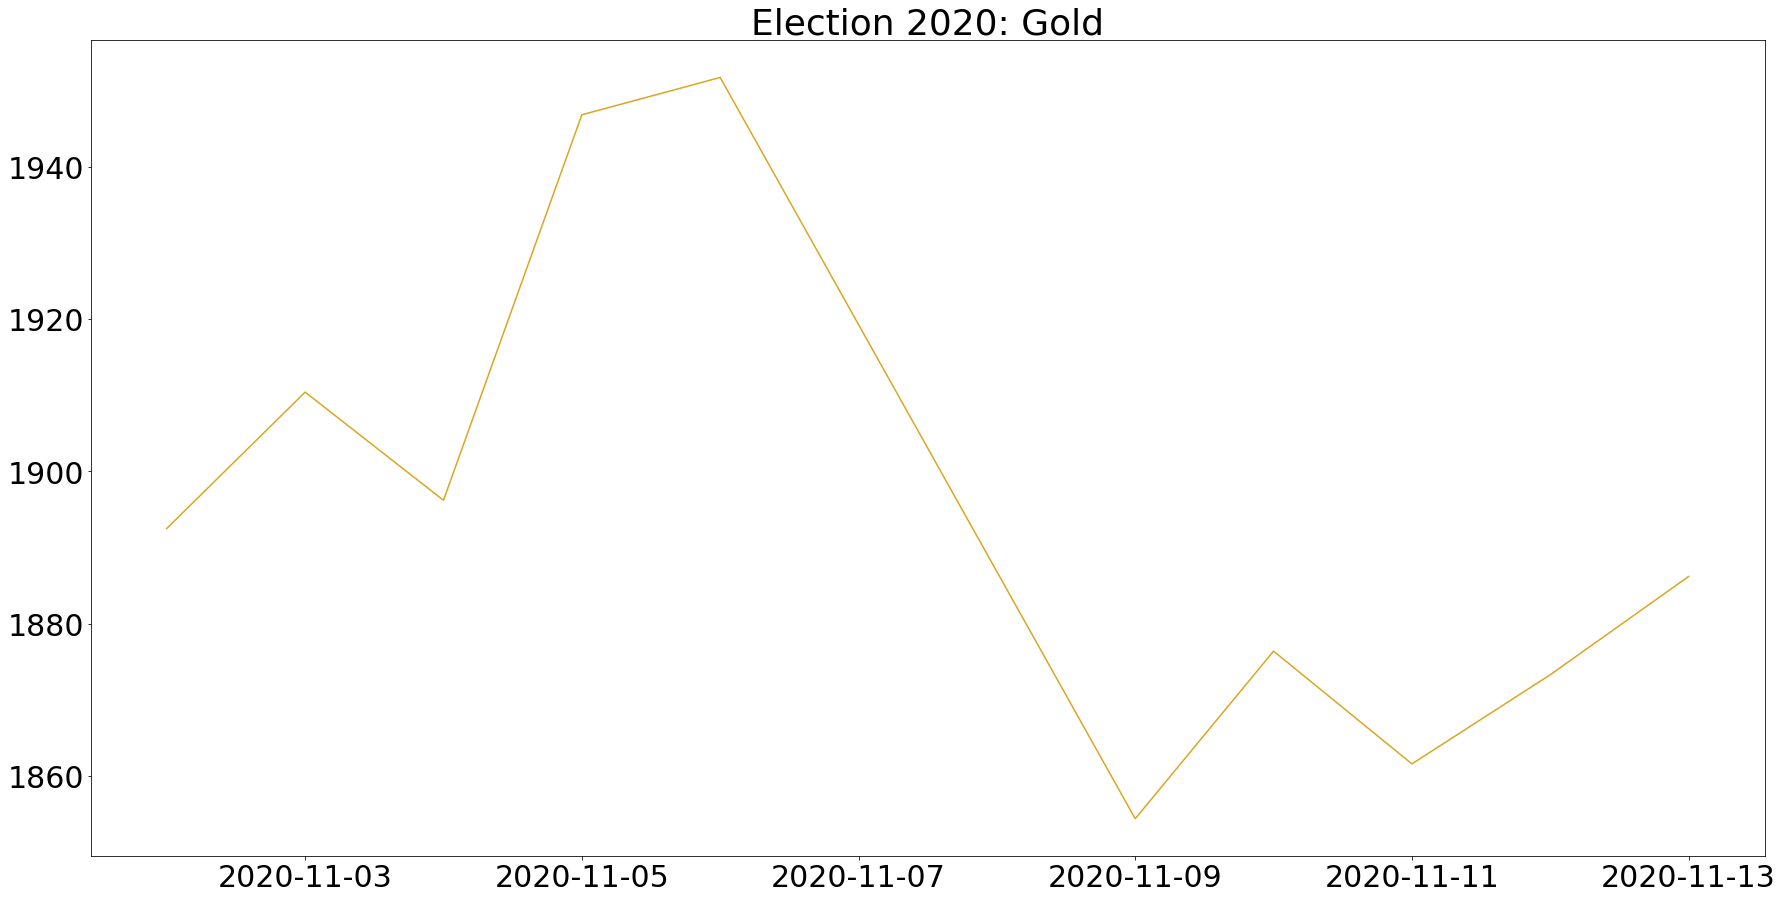

In [121]:
# Plotting gold 

Gold = plt.plot(all_y, gold_x, color=color_gold, label="Gold")
fig.set_size_inches(10, 5, forward=True)
plt.title("Election 2020: Gold")
plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams.update({'font.size': 30})

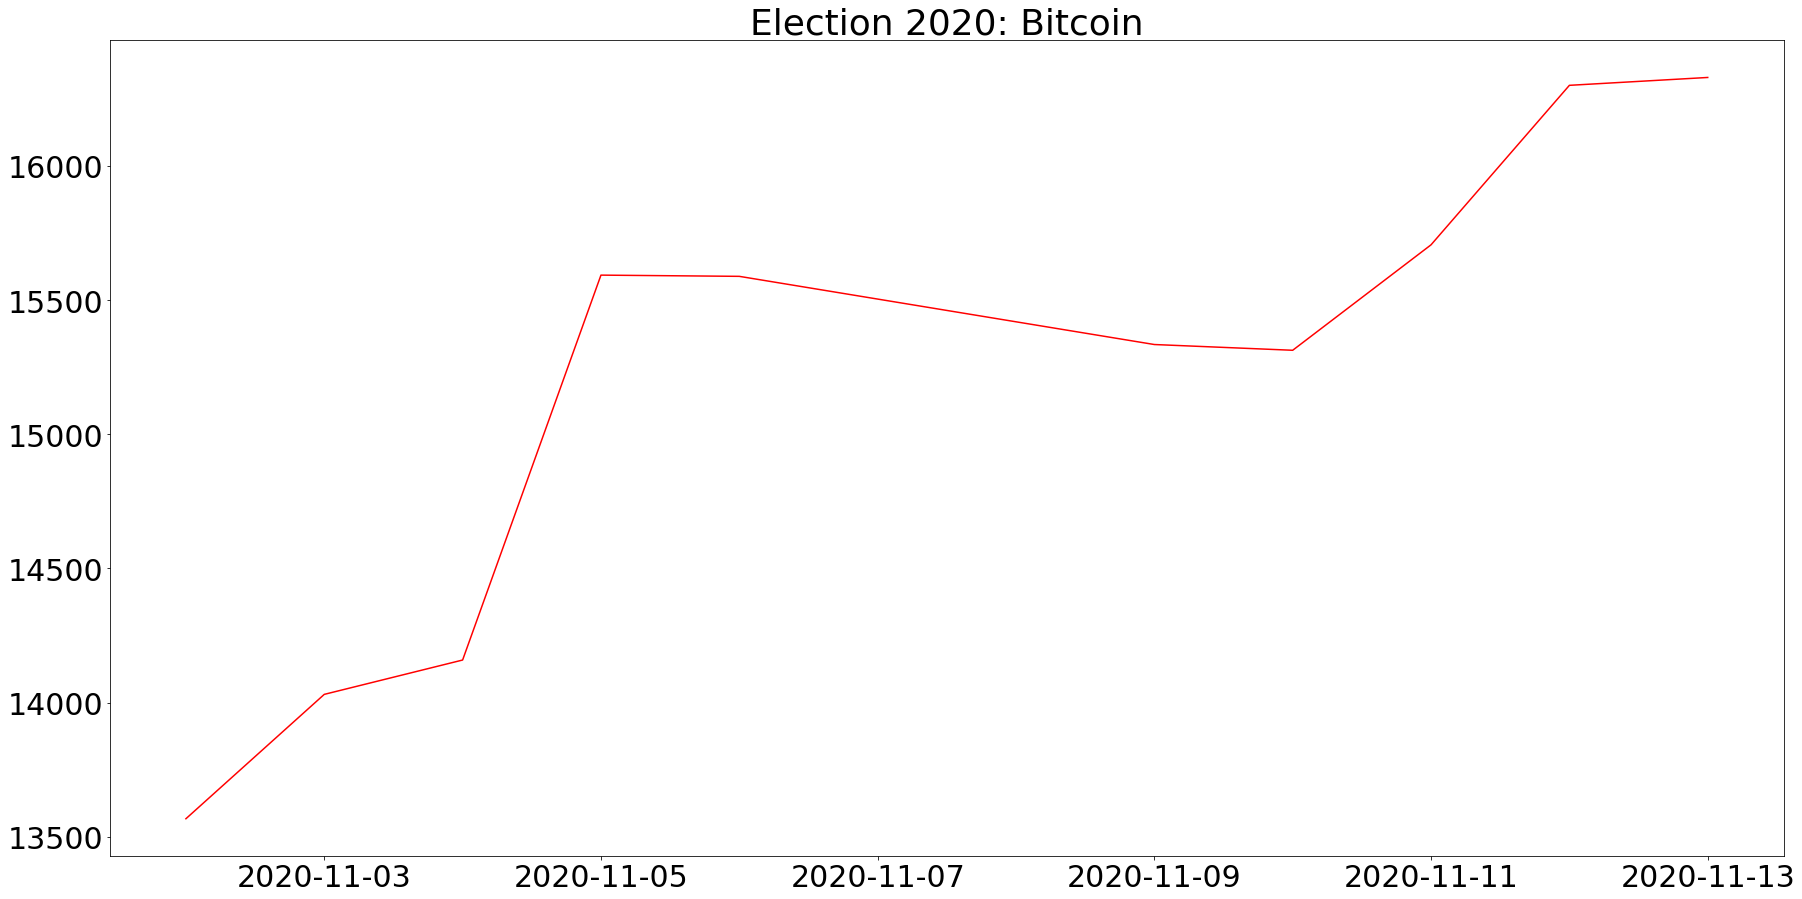

In [122]:
#Simple Bitcoin Plot
Bitcoin = plt.plot(all_y, bitcoin_x, color=color_bit, label="Bitcoin")
plt.title("Election 2020: Bitcoin")
plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams.update({'font.size': 30})

Bitcoin rose during uncertainty leading up to the election and fell somewhat soon after Biden was elected = Same as Gold.  This could be interpreted that it was behaving as a hedge investment and there was positive sentiment in the market once a President was declared.  However, Bitcoin did quickly recover and had a general positive correlation like the Dow. This could indicate that there was positive sentiment with Bitcoin and a Progressive administration. 

## Additional Data Analysis Exploration
Below is analysis we conducted and would like to explore more in the future. Specifically, we would like to look at the dates in the outliers below to see what was trending on social media and the news. 

In [123]:
# create a summary statistics table
stats_table = merged_wpct.describe()

# find IQR * 1.5 
bit_bound = (stats_table.iloc[6,3] - stats_table.iloc[4,3]) * 1.5
dow_bound = (stats_table.iloc[6,4] - stats_table.iloc[4,4]) * 1.5
gold_bound = (stats_table.iloc[6,5] - stats_table.iloc[4,5]) * 1.5

# find lower bounds for outliers
bit_lowbound = stats_table.iloc[4,3] - bit_bound
dow_lowbound = stats_table.iloc[4,4] - dow_bound
gold_lowbound = stats_table.iloc[4,5] - gold_bound

# create the upper bounds for outliers
bit_upbound = stats_table.iloc[6,3] + bit_bound
dow_upbound = stats_table.iloc[6,4] + dow_bound
gold_upbound = stats_table.iloc[6,5] + gold_bound



# pull bitcoin lower outliers from df
bit_lowout = merged_wpct.loc[merged_wpct['% Chg Bitcoin'] < bit_lowbound]
bit_lowout = bit_lowout[['Date','% Chg Bitcoin']]

# pull dow lower outliers from df
dow_lowout = merged_wpct.loc[merged_wpct['% Chg Dow'] < dow_lowbound]
dow_lowout = dow_lowout[['Date','% Chg Dow']]


# pull gold lower outliers from df
gold_lowout = merged_wpct.loc[merged_wpct['% Chg Gold'] < gold_lowbound]
gold_lowout = gold_lowout[['Date','% Chg Gold']]

# pull bitcoin upper outliers from df
bit_upout = merged_wpct.loc[merged_wpct['% Chg Bitcoin'] > bit_upbound]
bit_upout = bit_upout[['Date','% Chg Bitcoin']]

# pull dow upper outliers from df
dow_upout = merged_wpct.loc[merged_wpct['% Chg Dow'] > dow_upbound]
dow_upout = dow_upout[['Date','% Chg Dow']]

# pull gold upper outliers from df
gold_upout = merged_wpct.loc[merged_wpct['% Chg Gold'] > gold_upbound]
gold_upout = gold_upout[['Date','% Chg Gold']]



# merge all frames to view
bit_outliers = pd.merge(bit_lowout, bit_upout, on='Date', how='outer', suffixes=('_low', '_up'))
dow_outliers = pd.merge(dow_lowout, dow_upout, on='Date', how='outer', suffixes=('_low', '_up'))
gold_outliers = pd.merge(gold_lowout, gold_upout, on='Date', how='outer', suffixes=('_low', '_up'))

low_outliers = pd.merge(bit_lowout, dow_lowout, on='Date', how='outer')
low_outliers = pd.merge(low_outliers, gold_lowout, on='Date', how='outer')

up_outliers = pd.merge(bit_upout, dow_upout, on='Date', how='outer')
up_outliers = pd.merge(up_outliers, gold_upout, on='Date', how='outer')

all_outliers = pd.merge(low_outliers, up_outliers, on='Date', how='outer', suffixes=('_low', '_up'))

all_outliers = all_outliers.rename(columns={'% Chg Bitcoin_low': 'Bit Lower', 
                                   '% Chg Dow_low': 'Dow Lower',
                                   '% Chg Gold_low': 'Gold Lower', 
                                   '% Chg Bitcoin_up': 'Bit Upper', 
                                   '% Chg Dow_up': 'Dow Upper', 
                                   '% Chg Gold_up': 'Gold Upper'})
all_outliers_fill = all_outliers.fillna('..')

# bit_lowout
# bit_upout
# dow_lowout
# dow_upout
# gold_lowout
# gold_upout
# bit_outliers.fillna('..')
# dow_outliers.fillna('..')
# gold_outliers.fillna('..')
# low_outliers.fillna('..')
# up_outliers.fillna('..')
all_outliers.fillna('..')
# all_outliers_fill


# plt.savefig("../Images/sin_cos_with_markers.png")

,Date,Bit Lower,Dow Lower,Gold Lower,Bit Upper,Dow Upper,Gold Upper
0,2020-03-09,-0.133189,-0.0778572,..,..,..,..
1,2020-03-12,-0.381967,-0.0998845,-0.0316629,..,..,..
2,2020-03-16,-0.104075,-0.129265,..,..,..,..
3,2020-04-13,-0.0754462,..,..,..,..,..
4,2020-05-11,-0.113111,..,..,..,..,..
5,2020-09-04,-0.0893833,..,..,..,..,..
6,2020-11-27,-0.0837044,..,..,..,..,..
7,2020-02-24,..,-0.035582,..,..,..,..
8,2020-02-25,..,-0.0314527,..,..,..,..
9,2020-02-27,..,-0.0441786,..,..,..,..
